# **Regression Strategies for Predicting Energy Consumption in a Wastewater Treatment Plant**

The objective is to predict the energy consumption in the Wastewater Treatment Plant (WWTP)

**Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from scipy.stats import boxcox
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

**Data import**

In [2]:
df = pd.read_csv('data-melbourne.csv')

**Pre-processing**

Removing predictors with high correlation

In [3]:
df = df.drop(['VG','TM', 'Tm', 'VM'], axis=1)

Removing predictors with low information

In [4]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [5]:
df = df.drop(['year', 'month', 'day','SLP','PP', 'VV'], axis=1)

In [6]:
df.tail()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V,date
1377,5.068,4.716,305938,28.0,310.0,660.0,58.807,6.8,56,14.4,2019-06-20
1378,5.882,5.510,293446,40.0,250.0,700.0,60.671,7.6,71,13.5,2019-06-24
1379,4.638,4.811,307968,47.0,260.0,860.0,64.000,9.7,65,18.1,2019-06-25
1380,5.373,4.929,316675,46.0,300.0,900.0,62.479,10.9,65,21.9,2019-06-26
1381,4.072,5.194,318268,31.0,270.0,910.0,63.312,12.4,63,28.0,2019-06-27


In [7]:
df['total_grid'] = (df['total_grid']/1000)

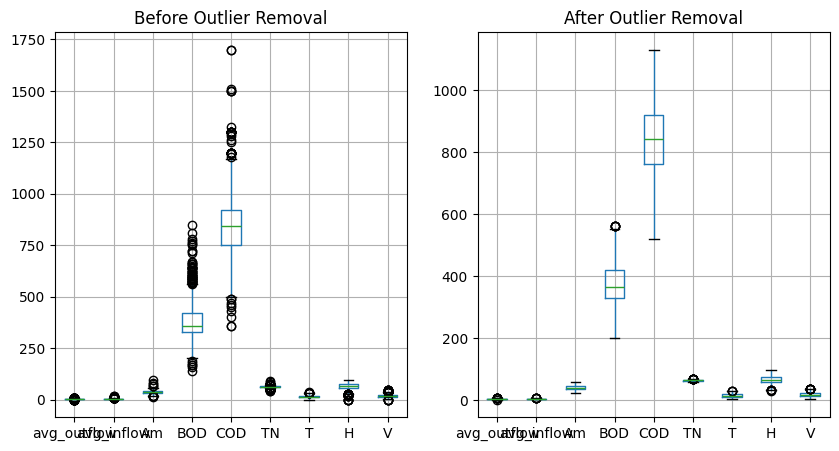

In [8]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(df):
    for col in df.select_dtypes(include=[np.number]).columns:  # Apply only to numerical columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out values outside the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Apply function to remove outliers
df_cleaned = remove_outliers_iqr(df)

df_pred = df.drop(['total_grid'],axis=1)
df_cleaned_pred = df_cleaned.drop(['total_grid'],axis=1)

# Boxplot to visualize before and after
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
df_pred.boxplot()
plt.title("Before Outlier Removal")

plt.subplot(1, 2, 2)
df_cleaned_pred.boxplot()
plt.title("After Outlier Removal")

plt.show()


In [9]:
df_cleaned.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V,date
0,2.941,2.589,175.856,27.0,365.0,730.0,60.378,19.3,56,26.9,2014-01-01
1,2.936,2.961,181.624,25.0,370.0,740.0,60.026,17.1,63,14.4,2014-01-02
2,2.928,3.225,202.016,42.0,418.0,836.0,64.522,16.8,47,31.9,2014-01-05
3,2.928,3.354,207.547,36.0,430.0,850.0,63.000,14.6,49,27.0,2014-01-06
4,2.917,3.794,202.824,46.0,508.0,1016.0,65.590,13.4,65,20.6,2014-01-07


In [10]:
df_cleaned.shape

(1003, 11)

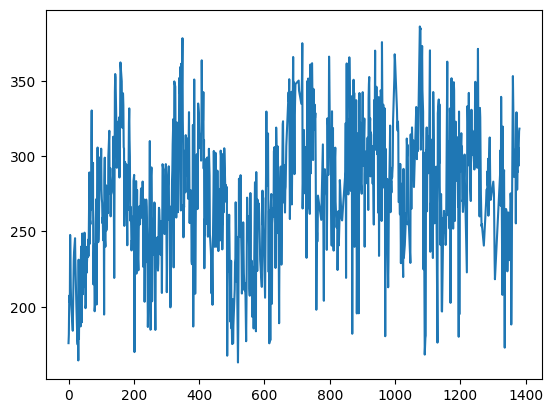

In [11]:
plt.plot(df_cleaned['total_grid'])

Solving skewness

In [12]:
avg_inflow_bcx, lambda_avg_inflow = boxcox(df_cleaned['avg_inflow'])
bod_bcx, lambda_bod = boxcox(df_cleaned['BOD'])
cod_bcx, lambda_cod = boxcox(df_cleaned['COD'])

In [13]:
df_cleaned['avg_inflow'] = avg_inflow_bcx
df_cleaned['BOD'] = bod_bcx
df_cleaned['COD'] = cod_bcx

In [14]:
df_cleaned.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,H,V,date
0,2.941,0.626349,175.856,27.0,6.075368,118.116422,60.378,19.3,56,26.9,2014-01-01
1,2.936,0.677426,181.624,25.0,6.089792,119.201080,60.026,17.1,63,14.4,2014-01-02
2,2.928,0.706689,202.016,42.0,6.219193,129.375415,64.522,16.8,47,31.9,2014-01-05
3,2.928,0.719353,207.547,36.0,6.249241,130.825462,63.000,14.6,49,27.0,2014-01-06
4,2.917,0.756216,202.824,46.0,6.426383,147.451586,65.590,13.4,65,20.6,2014-01-07


Centering and scaling predictors

In [15]:
df_normalised = df_cleaned.copy()
# df_normalised = df.copy()

In [16]:
df_normalised = df_normalised.drop(['date'], axis=1)

In [17]:
columns_to_plot = ['avg_outflow','avg_inflow','Am','BOD','COD','TN','T','H','V']

means = df[columns_to_plot].mean()
stds = df[columns_to_plot].std()

df_normalised[columns_to_plot] = (df[columns_to_plot] - means) / stds

Changing Energy Consumption unit from kWh to MWh for readibility purposes

In [18]:
# df_normalised['total_grid'] = (df_normalised['total_grid']/1000)

##### **Model accuracy metrics**

**Residual Sum of Squares**

In [19]:
def calc_rss(y, y_pred):
    rss = sum((y - y_pred)**2)
    
    return rss

**Total Sum of Squares**

In [20]:
def calc_tss(y):
    n = len(y)
    y_avg = sum(y)/n
    tss = sum((y - y_avg)**2)

    return tss

**Root Mean Squared Error**

In [21]:
def calc_rmse(y, y_pred):
    n = len(y)
    mse = (sum((y - y_pred)**2))/n
    rmse = mse**(1/2)
    
    return rmse

$\mathbf{R^2}$

In [22]:
def calc_r2(y, y_pred):
    rss = calc_rss(y, y_pred)
    tss = calc_tss(y)
    r2 = 1 - (rss/tss)

    return r2

##### **Train and test datasets**

In [23]:
X = df_normalised.copy()
X = X.drop(['total_grid'], axis=1)

y = df_normalised['total_grid']

In [24]:
X.insert(0, 'intercept', 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=False)

In [26]:
X_train.head()

,intercept,avg_outflow,avg_inflow,Am,BOD,COD,TN,T,H,V
0,1,-0.805359,-1.331870,-1.574715,-0.198401,-0.797436,-0.661643,0.789723,-0.520057,1.039293
1,1,-0.809428,-1.073462,-1.832394,-0.140259,-0.728668,-0.760214,0.382202,-0.038434,-0.712176
2,1,-0.815939,-0.890076,0.357877,0.417906,-0.068496,0.498805,0.326631,-1.139286,1.739880
3,1,-0.815939,-0.800466,-0.415160,0.557448,0.027779,0.072597,-0.080890,-1.001679,1.053304
4,1,-0.824891,-0.494822,0.873235,1.464467,1.169328,0.797877,-0.303175,0.099172,0.156552


In [27]:
X_test.head()

,intercept,avg_outflow,avg_inflow,Am,BOD,COD,TN,T,H,V
1008,1,0.672531,0.495047,-1.574715,-0.256543,0.096547,0.442518,1.401005,-0.520057,0.408764
1009,1,0.601729,0.470735,-1.574715,-0.605397,-0.316061,-0.850944,0.215489,0.030369,-0.235777
1010,1,0.480471,0.132443,-0.415160,-0.954250,0.096547,0.263859,0.567439,-0.038434,-0.936364
1011,1,1.204767,0.260257,-0.286320,0.475816,-0.000003,0.590375,1.160197,-1.139286,-0.291824
1012,1,0.137040,0.599244,0.873235,1.255155,-0.247293,0.083799,1.641813,-1.276892,0.520858


In [28]:
len(y_test)

251

### **Task 1 - Ordinary Linear Square (OLS) Regression**

$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p + \epsilon$

$\hat{y} = \hat{\beta_0} + \hat{\beta_1} x_1 + \hat{\beta_2} x_2 + \cdots + \hat{\beta_p} x_p$

$RSS = \displaystyle \sum_{i=1}^n (y_i - \hat{y_i})^2 = \sum_{i=1}^{n}(y_1 - \hat{\beta_0} - \hat{\beta_1}x_{i1} - \hat{\beta_2}x_{i2} - \cdots - \hat{\beta_p}x_{ip})^2$

$\hat{\beta} = (\mathbf{X}^T X)^{-1} \mathbf{X}^T y$

#### **From scratch**

In [29]:
def ica_linear_regression(X_train, y_train, X_test, y_test):
    X_T = X_train.T
    B = np.linalg.inv(X_T @ X_train) @ X_T @ y_train

    y_pred = np.dot(X_test, B)

    RMSE = calc_rmse(y_test, y_pred)
    R2 = calc_r2(y_test, y_pred)

    return RMSE, R2, y_pred

In [30]:
def ica_ridge_regression(L, X_train, y_train, X_test, y_test):
    I = np.identity(X_train.shape[1])

    X_T = X_train.T
    B_ridge = np.linalg.inv(L*I + X_T @ X_train) @ X_T @ y_train

    y_pred_ridge = np.dot(X_test, B_ridge)

    RMSE = calc_rmse(y_test, y_pred_ridge)
    R2 = calc_r2(y_test, y_pred_ridge)
    

    return RMSE, R2, B_ridge

In [31]:
def lasso_regression(B, X_train, y_train, L):
    rss = np.sum((y_train - np.dot(X_train, B)) ** 2)
    
    l1_penalty = L * np.sum(np.abs(B[1:]))

    total_loss = rss + l1_penalty
    return total_loss

In [32]:
def ica_lasso_regression(X_train, y_train, X_test, y_test, L):
    x0 = np.random.randn(X_train.shape[1])
    
    res = minimize(lasso_regression, x0, args=(X_train, y_train, L))
    
    B_lasso = res.x
    
    y_pred_lasso = np.dot(X_test, B_lasso)

    RMSE = calc_rmse(y_test, y_pred_lasso)
    R2 = calc_r2(y_test, y_pred_lasso)
    
    return RMSE, R2, B_lasso

In [33]:
def ica_kfold_cross_validation(k, X_train, y_train, model, *args):
    
    n_train = len(X_train)
    fold_length = round(n_train/k)

    indices = np.array(X_train.index)

    k_rmse = np.zeros(k)
    k_r2 = np.zeros(k)

    for fold in range(k):
        start_idx = fold* fold_length
        end_idx = (fold + 1) * fold_length

        validation_indices = indices[start_idx:end_idx]

        train_indices = np.setdiff1d(indices, validation_indices)

        X_train_fold = X_train.loc[train_indices]
        X_val_fold = X_train.loc[validation_indices]

        y_train_fold = y_train.loc[train_indices]
        y_val_fold = y_train.loc[validation_indices]

        if model=='linear_regression':

            rmse, r2, y_pred = ica_linear_regression(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        elif model=='ridge_regression':
            L = args[0]
            rmse, r2, B_ridge = ica_ridge_regression(L, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        elif model=='lasso_regression':
            L = args[0]
            B0 = args[1:]
            rmse, r2, B_lasso = ica_lasso_regression(X_train, y_train, X_test, y_test, L)            

        # print(str(fold+1)+": RMSE = " + str(rmse) + " R2 = " + str(r2))
        k_rmse[fold] = rmse
        k_r2[fold] = r2

    return k_rmse, k_r2

##### **No Cross-Validation**

In [34]:
rmse, r2, y_pred_olr = ica_linear_regression(X_train, y_train, X_test, y_test)
print(rmse, r2)

41.52819186098981 -0.06139926262940376


In [35]:
time_test = df_cleaned['date'][len(df_cleaned['date'])-len(y_test):]
# time_test = df['date'][len(df['date'])-len(y_test):]

In [36]:
df_cleaned.shape

(1003, 11)

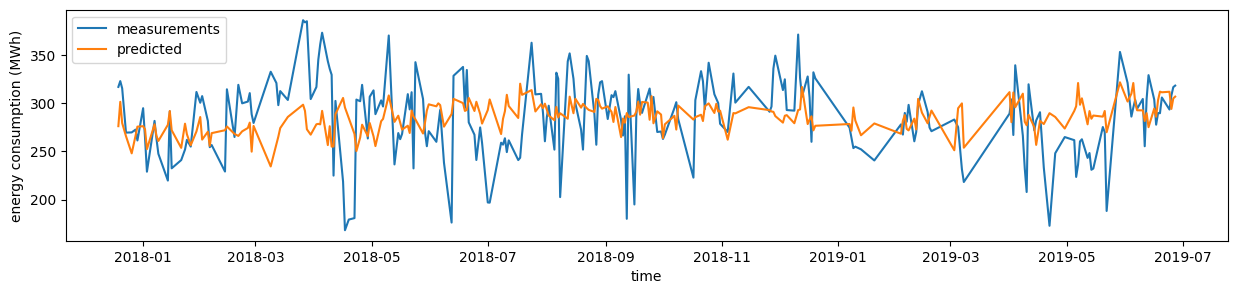

In [37]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_test, label='measurements')
plt.plot(time_test, y_pred_olr, label='predicted')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

In [38]:
len(df_cleaned)

1003

##### **5-fold Cross-validation**

In [39]:
k = 5

rmse_olr_k5, r2_olr_k5 = ica_kfold_cross_validation(5, X_train, y_train, 'linear_regression')

#### **10-Fold Cross-Validation**

In [40]:
k = 10

rmse_olr_k10, r2_olr_k10 = ica_kfold_cross_validation(k, X_train, y_train, 'linear_regression')

#### **From libraries**

##### **No Cross-validation**

In [41]:
import statsmodels.api as sm

model1 = sm.OLS(y_train, X_train)
results1 = model1.fit()

y_pred_olr_lib = results1.predict(X_test)

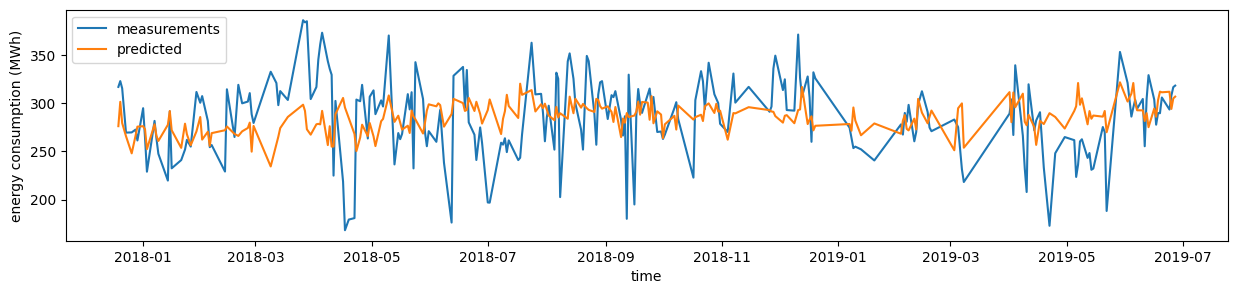

In [42]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_test, label='measurements')
plt.plot(time_test, y_pred_olr_lib, label='predicted')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

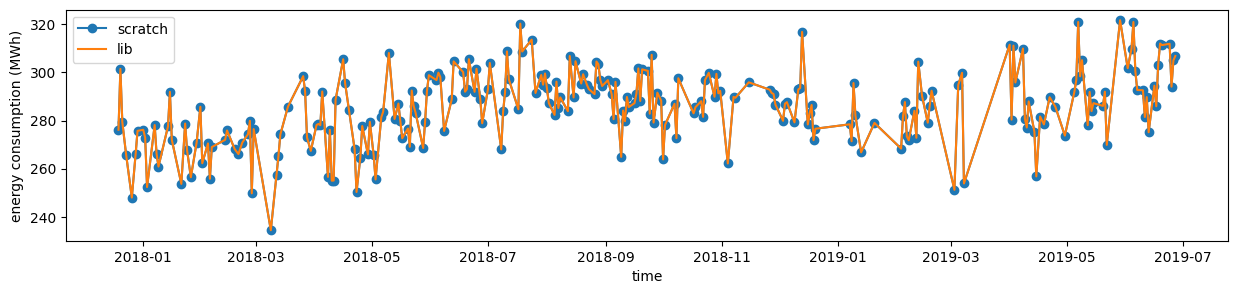

In [43]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_pred_olr, label='scratch', marker='o')
plt.plot(time_test, y_pred_olr_lib, label='lib')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

##### **5-Fold Cross Validation**

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [45]:
lm = LinearRegression()

In [46]:
k = 5

r2_olr_lib_k5 = cross_val_score(lm, X_train, y_train, scoring='r2', cv=k)
rmse_olr_lib_k5 = cross_val_score(lm, X_train, y_train, scoring='neg_root_mean_squared_error', cv=k)

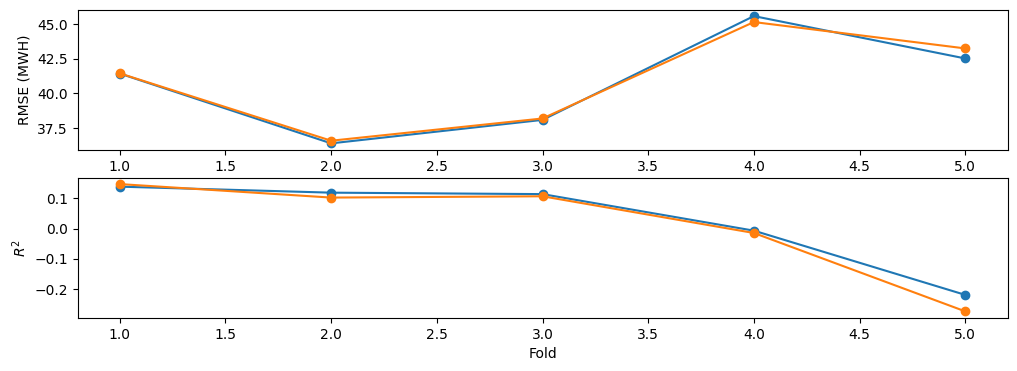

In [47]:
K = np.arange(0, 5)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,4))

ax1.plot(K+1, rmse_olr_k5, marker='o', label = 'scratch')
ax1.plot(K+1, -rmse_olr_lib_k5, marker='o', label='lib')
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE (MWH)')

ax2.plot(K+1, r2_olr_k5, marker='o', label='scratch')
ax2.plot(K+1, r2_olr_lib_k5, marker='o', label='lib')
ax2.set_xlabel('Fold')
ax2.set_ylabel('$R^2$')

plt.show()

##### **10-Fold Cross-Validation**

In [48]:
k = 10

r2_olr_lib_k10 = cross_val_score(lm, X_train, y_train, scoring='r2', cv=k)
rmse_olr_lib_k10 = cross_val_score(lm, X_train, y_train, scoring='neg_root_mean_squared_error', cv=k)

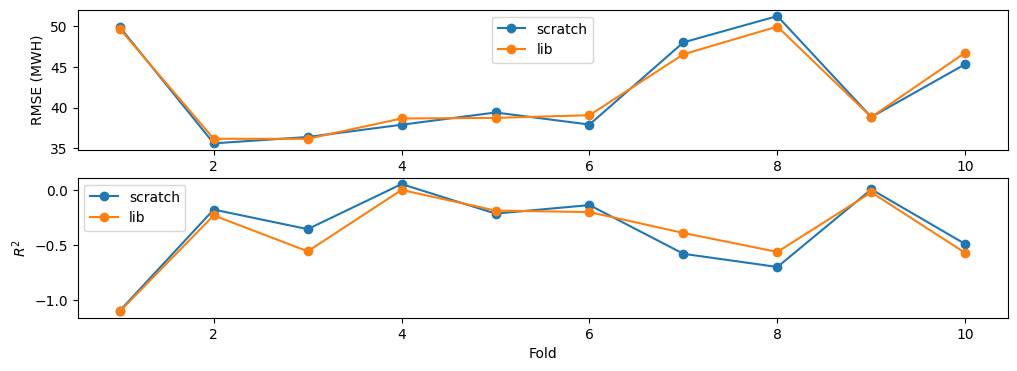

In [49]:
K = np.arange(0, 10)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,4))

ax1.plot(K+1, rmse_olr_k10, marker='o', label = 'scratch')
ax1.plot(K+1, -rmse_olr_lib_k10, marker='o', label='lib')
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE (MWH)')

ax2.plot(K+1, r2_olr_k10, marker='o', label='scratch')
ax2.plot(K+1, r2_olr_lib_k10, marker='o', label='lib')
ax2.set_xlabel('Fold')
ax2.set_ylabel('$R^2$')

ax1.legend()
ax2.legend()

plt.show()

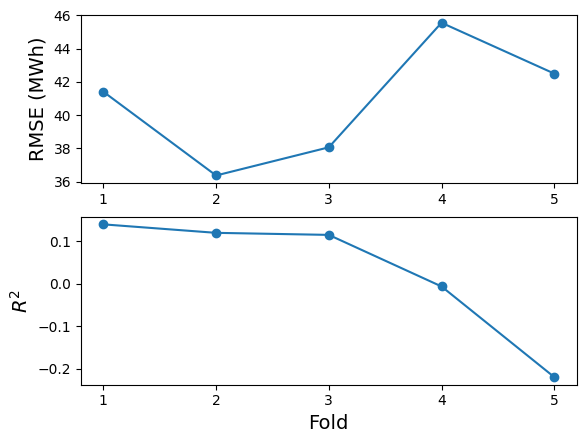

In [50]:
K = np.arange(0, 5)

fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(K+1, rmse_olr_k5, marker='o', label = 'scratch')
ax1.set_ylabel('RMSE (MWh)', fontsize=14)

ax2.plot(K+1, r2_olr_k5, marker='o', label='scratch')
ax2.set_xlabel('Fold', fontsize=14)
ax2.set_ylabel('$R^2$', fontsize=14)

ax1.set_xticks(K + 1)  # Set tick marks at each fold
ax2.set_xticks(K + 1)  # Ensure consistency on both plots

# fig.savefig('../ica2024-report/homework2/figures/5-fold-variability.pdf', format='pdf', bbox_inches='tight')

plt.show()

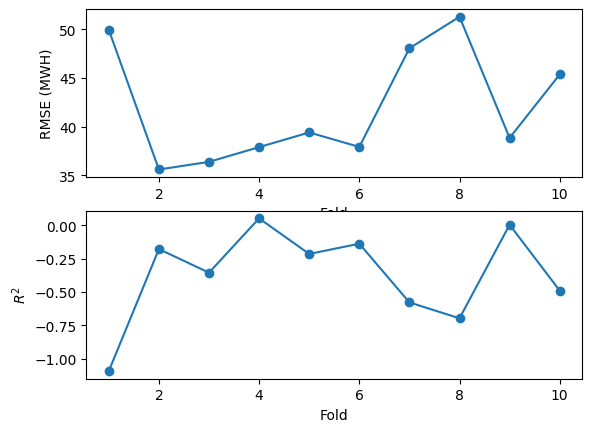

In [51]:
K = np.arange(0, 10)

fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(K+1, rmse_olr_k10, marker='o', label = 'scratch')
# ax1.plot(K+1, -rmse_olr_lib_k10, marker='o', label='lib')
ax1.set_xlabel('Fold')
ax1.set_ylabel('RMSE (MWH)')

ax2.plot(K+1, r2_olr_k10, marker='o', label='scratch')
# ax2.plot(K+1, r2_olr_lib_k10, marker='o', label='lib')
ax2.set_xlabel('Fold')
ax2.set_ylabel('$R^2$')

# ax1.legend()
# ax2.legend()

plt.show()

### **Task 2: Penalised Linear Regression**

#### **From scratch**

#### **Ridge Regression ($l_2$ penalty)**

*(James, Gareth, et al. 2013)* The Ridge Regression coefficients estimates $\hat{\beta}^R$ are the values that minimize

$\displaystyle \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 = RSS + \lambda \sum_{j=1}^p \beta_j^2$

*(Hastie et al. 2017)* The closed form of the Ridge Regression is given by

$\hat{\mathbf{\beta}}^{ridge} = (\mathbf{X^T \mathbf{X}} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$

In [52]:
X_train.shape

(752, 10)

In [53]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))
B_Ridge_L = np.zeros((len(L), X_train.shape[1]))

for i in range(0,len(L)):
    l = L[i]
    RMSE, R2, B_ridge = ica_ridge_regression(l, X_train, y_train, X_test, y_test)
    rmse_L[i] = RMSE
    r2_L[i] = R2
    B_Ridge_L[i,:] = B_ridge

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\1966073017.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


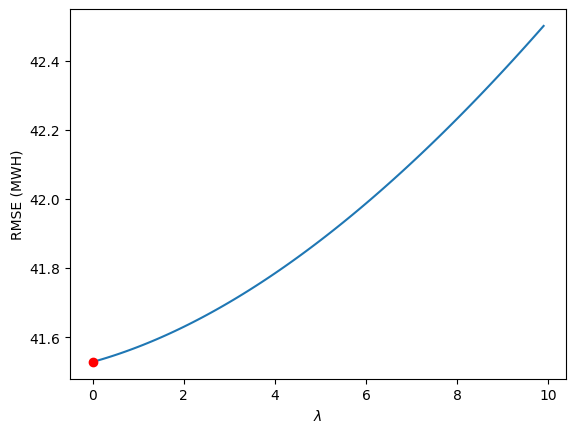

In [54]:
plt.plot(L, rmse_L)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE (MWH)')

min_index = np.argmin(rmse_L)
lambda_min_ridge = L[min_index]
rmse_min_ridge = rmse_L[min_index]

plt.scatter(lambda_min_ridge, rmse_min_ridge, color='red', zorder=2)

plt.show()


In [55]:
B_min_ridge = B_Ridge_L[min_index]

y_pred_ridge = np.dot(X_test, B_min_ridge)

In [56]:
rmse_ridge = calc_rmse(y_test, y_pred_ridge)
r2_ridge = calc_r2(y_test, y_pred_ridge)

print(rmse_ridge)
print(r2_ridge)

41.52819186098981
-0.06139926262940376


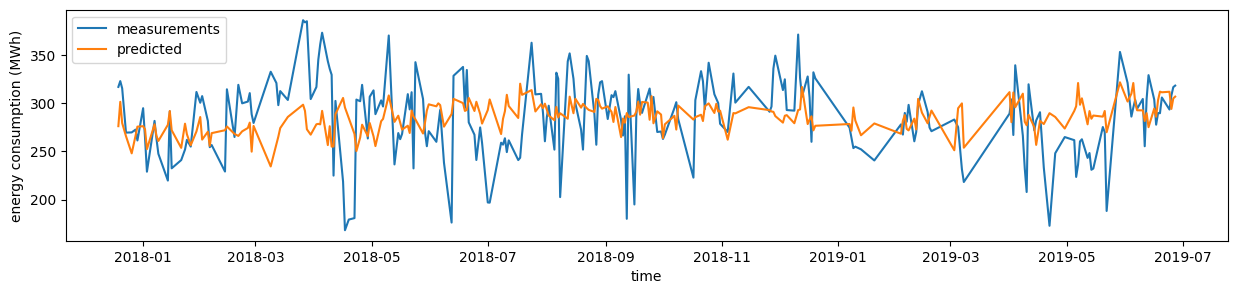

In [57]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_test, label='measurements')
plt.plot(time_test, y_pred_ridge, label='predicted')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

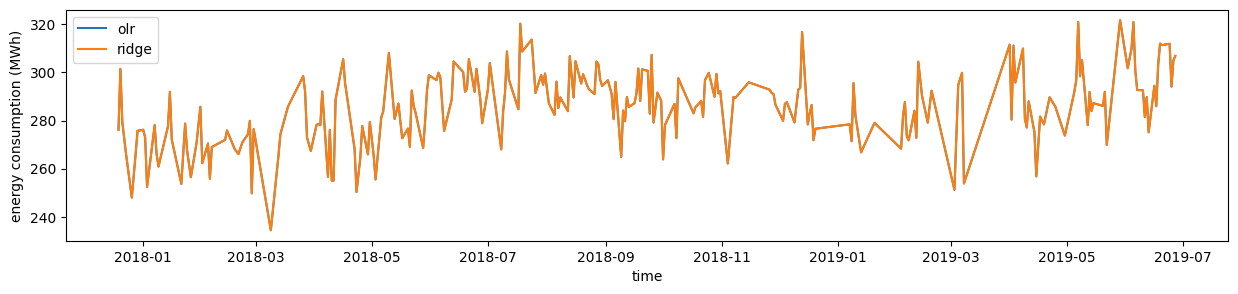

In [58]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_pred_olr, label='olr')
plt.plot(time_test, y_pred_ridge, label='ridge')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

##### **5-fold Cross Validation**

In [59]:
L = np.arange(0,10,0.1)
k = 5

rmse_L_k5 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'ridge_regression', l)
    rmse_L_k5[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\3970641427.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


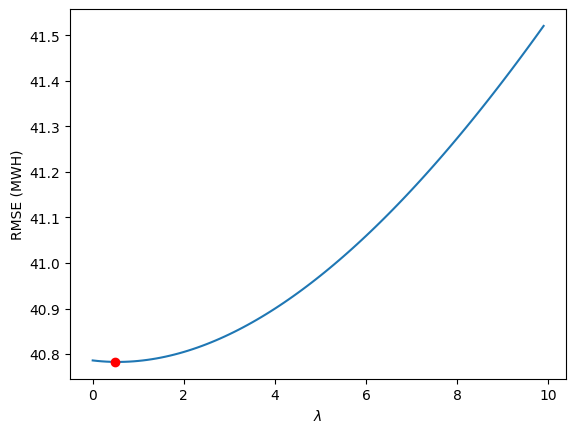

In [60]:
plt.plot(L, rmse_L_k5, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE (MWH)')

min_index = np.argmin(rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, rmse_min_k5, color='red', zorder=2)

plt.show()

In [61]:
B_min_ridge = B_Ridge_L[min_index]

y_pred_ridge = np.dot(X_test, B_min_ridge)

rmse_ridge = calc_rmse(y_test, y_pred_ridge)
r2_ridge = calc_r2(y_test, y_pred_ridge)

print(rmse_ridge)
print(r2_ridge)

41.54831375783376
-0.0624280837612754


##### **10-Fold Cross-Validation**

In [62]:
L = np.arange(0,10,0.1)
k = 10

rmse_L_k10 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'ridge_regression', l)
    rmse_L_k10[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\3245871270.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


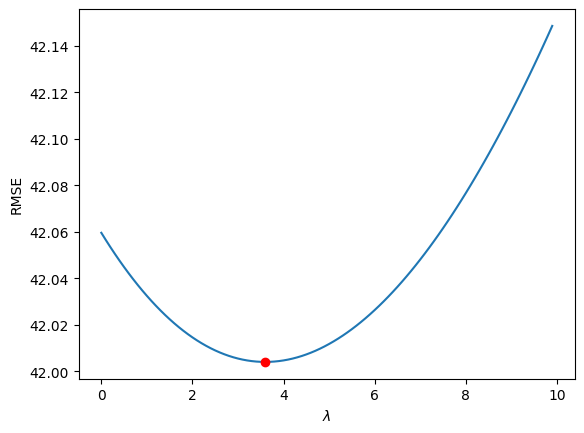

In [63]:
plt.plot(L, rmse_L_k10, zorder=1)

min_index = np.argmin(rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, rmse_min_k10, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

In [64]:
B_min_ridge = B_Ridge_L[min_index]

y_pred_ridge = np.dot(X_test, B_min_ridge)

rmse_ridge = calc_rmse(y_test, y_pred_ridge)
r2_ridge = calc_r2(y_test, y_pred_ridge)

print(rmse_ridge)
print(r2_ridge)

41.749881282969376
-0.07276161820511229


#### **Lasso Regression ($l_1$ penalty)**

(Jamie et al. 2013) The lasso coefficients $\beta_{\lambda}^L$, minimize the quantity

$\displaystyle \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^p |\beta_j| = RSS + \lambda \sum_{j=1}^p |\beta_j|$

(Hastie et al. 2017) We can write the residual sum of squares as

$RSS(\beta) = (\mathbf{y} - \mathbf{X}\beta)^T(\mathbf{y} - \mathbf{X}\beta)$

Differentiating with respect to $\beta$ we obtain

$\cfrac{\partial RSS}{\partial \beta} = -2\mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta)$

For the absolute value function $f(\beta) = |\beta|$, we have

$\partial f(\beta) =
\begin{cases}
{+1} & \text{if} \beta > 0\\
{-1} & \text{if} \beta < 0\\
[-1,+1] & \text{if} \beta = 0.
\end{cases}$

In [65]:
from scipy.optimize import minimize

In [66]:
X_train.shape

(752, 10)

In [67]:
x0 = np.ones(X_train.shape[1])
res = minimize(lasso_regression, x0, args=(X_train, y_train, 1), options={'xatol': 1e-8, 'disp':False})
B_lasso = res.x
print(B_lasso)

[277.95363238   7.59801573   8.71023852  -5.75591241  -4.56832574
  14.25750492 -12.26426004 -12.43433482   0.87214647   1.20036995]


C:\Users\room2\AppData\Local\Temp\ipykernel_12596\3228864536.py:2: OptimizeWarning: Unknown solver options: xatol
  res = minimize(lasso_regression, x0, args=(X_train, y_train, 1), options={'xatol': 1e-8, 'disp':False})


In [68]:
rmse_lasso, r2_lasso, B_lasso = ica_lasso_regression(X_train, y_train, X_test, y_test, 1)
print(rmse_lasso)
print(r2_lasso)
print(B_lasso)

41.52833232063757
-0.06140644252392846
[277.95361707   7.59803399   8.71020271  -5.75592443  -4.56833675
  14.25750616 -12.26421935 -12.43435166   0.87214556   1.2003716 ]


In [69]:
L = np.arange(0,40000,1000)
rmse_lasso_L = np.zeros(len(L))
r2_lasso_L = np.zeros(len(L))
B_Lasso_L = np.zeros((len(L), X_train.shape[1]))

for i in range(0,len(L)):
    l = L[i]
    RMSE, R2, B_lasso = ica_lasso_regression(X_train, y_train, X_test, y_test, l)
    rmse_lasso_L[i] = RMSE
    r2_lasso_L[i] = R2
    B_Lasso_L[i,:] = B_lasso

min_index = np.argmin(rmse_lasso_L)
lambda_min_lasso = L[min_index]
rmse_min_lasso = rmse_lasso_L[min_index]

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\747857144.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


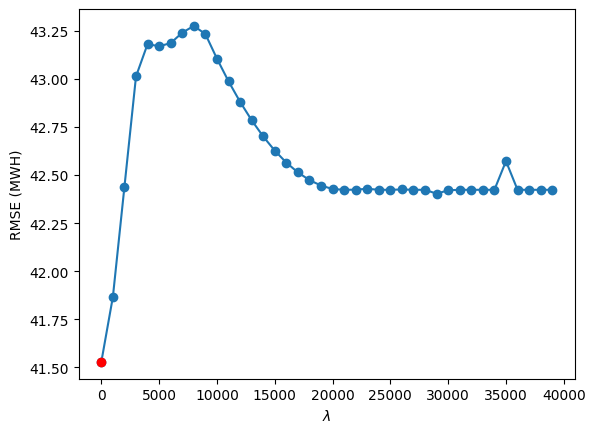

In [70]:
plt.plot(L, rmse_lasso_L, marker='o')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE (MWH)')

plt.scatter(lambda_min_lasso, rmse_min_lasso, color='red', zorder=2)

plt.show()

In [71]:
B_min_lasso = B_Lasso_L[min_index]

print(B_min_lasso)

y_pred_lasso = np.dot(X_test, B_min_lasso)

[277.95528725   7.59754969   8.71302514  -5.75665889  -4.56977415
  14.26319466 -12.271392   -12.43322458   0.87304618   1.20165845]


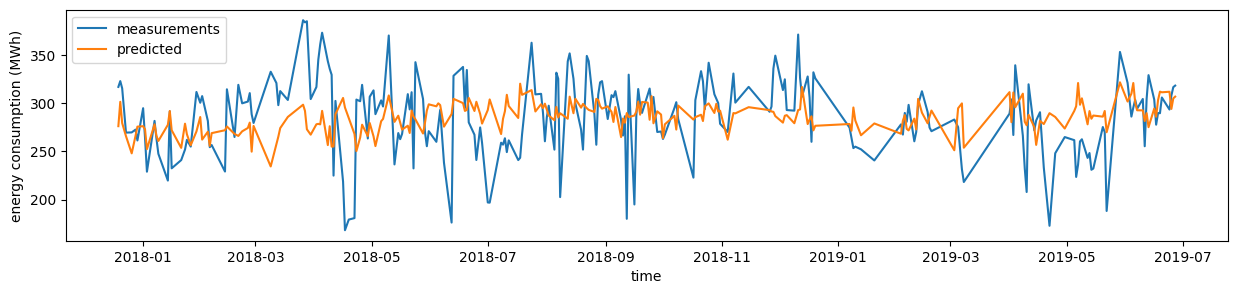

In [72]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_test, label='measurements')
plt.plot(time_test, y_pred_lasso, label='predicted')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

In [73]:
rmse_lasso = calc_rmse(y_test, y_pred_lasso)
r2_lasso = calc_r2(y_test, y_pred_lasso)

print(rmse_lasso)
print(r2_lasso)

41.52819196230049
-0.06139926780810656


##### **5-Fold Cross-Validation**

In [74]:
L = np.arange(0,500,10)
k = 5

rmse_L_k5 = np.zeros((len(L),1))

B0 = np.zeros(X_train.shape[1])

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'lasso_regression', l, B0)
    rmse_L_k5[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\1342231524.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


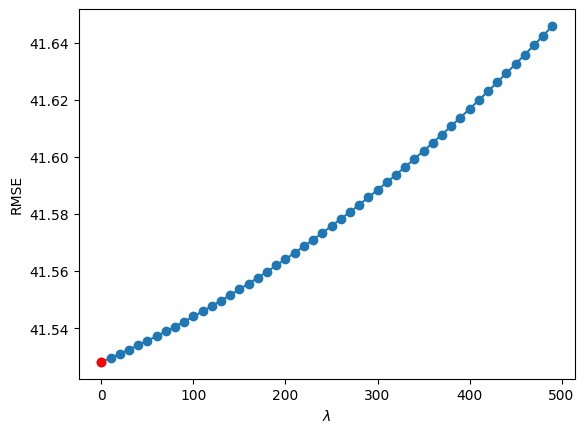

In [75]:
plt.plot(L, rmse_L_k5, zorder=1, marker='o')

min_index = np.argmin(rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, rmse_min_k5, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

##### **10-Fold Cross-Validation**

In [76]:
L = np.arange(0,100,1)
k = 10

rmse_L_k10 = np.zeros((len(L),1))

B0 = np.zeros(X_train.shape[1])

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'lasso_regression', l, B0)
    rmse_L_k10[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\3245871270.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


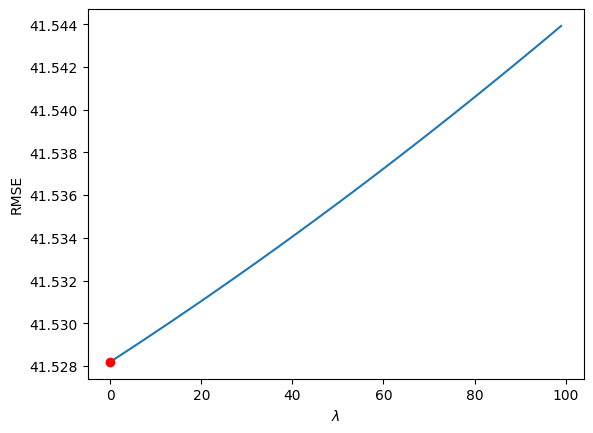

In [77]:
plt.plot(L, rmse_L_k10, zorder=1)

min_index = np.argmin(rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, rmse_min_k10, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

#### **From libraries**

#### **Ridge Regression ($l_2$ penalty)**

In [78]:
from sklearn.linear_model import Ridge

In [79]:
ridgereg = Ridge(alpha=1.0)
ridgereg.fit(X_train, y_train)
y_pred_ridge = ridgereg.predict(X_test)


In [80]:
calc_rmse(y_test, y_pred_ridge)
calc_r2(y_test, y_pred_ridge)

-0.061587856996936585

In [81]:
L = np.arange(0,4000,100)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    
    ridgereg = Ridge(alpha=l)
    ridgereg.fit(X_train, y_train)
    y_pred_ridge = ridgereg.predict(X_test)
    
    rmse_L[i] = calc_rmse(y_test, y_pred_ridge)
    r2_L[i] = calc_r2(y_test, y_pred_ridge)

    

In [82]:
min_index = np.argmin(rmse_L)
lambda_min = L[min_index]
rmse_min = rmse_L[min_index]

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\3169327214.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


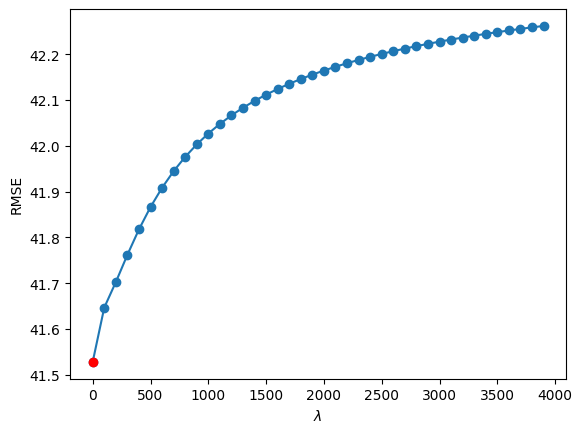

In [83]:
plt.plot(L, rmse_L, marker='o')

plt.scatter(lambda_min, rmse_min, color='red', zorder=2)

plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

In [84]:
lambda_min

0

In [85]:
ridgereg = Ridge(alpha=lambda_min)
ridgereg.fit(X_train, y_train)
y_pred_ridge_lib = ridgereg.predict(X_test)

In [86]:
calc_rmse(y_test, y_pred_ridge_lib)
calc_r2(y_test, y_pred_ridge_lib)

-0.06139926262940398

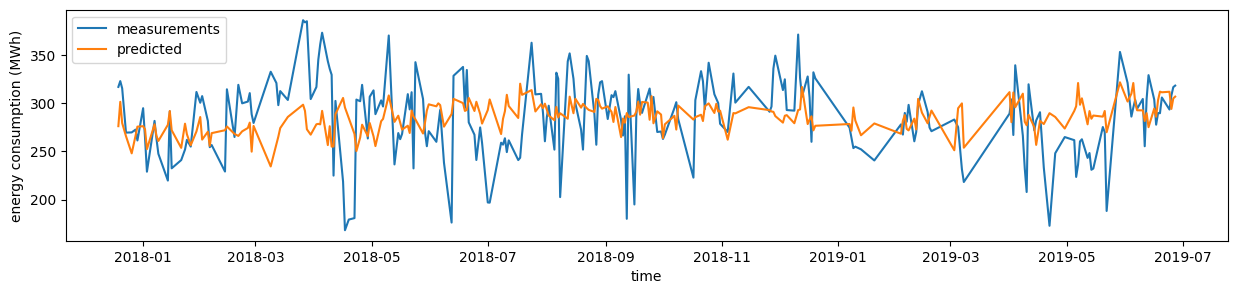

In [87]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_test, label='measurements')
plt.plot(time_test, y_pred_ridge_lib, label='predicted')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

##### **5-Fold Cross-Validation**

In [88]:
lm = LinearRegression()

L = np.arange(0,100,0.1)
k = 5

rmse_L_k5 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]

    ridgereg = Ridge(alpha=l)

    rmse = cross_val_score(ridgereg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=k)
    rmse_L_k5[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\2351975880.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


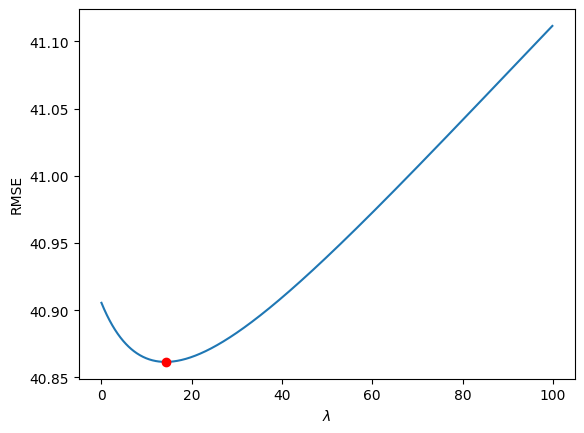

In [89]:
plt.plot(L, -rmse_L_k5, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(-rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, -rmse_min_k5, color='red', zorder=2)

##### **10-Fold Cross-Validation**

In [90]:
lm = LinearRegression()

L = np.arange(0,100,0.1)
k = 10

rmse_L_k10 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]

    ridgereg = Ridge(alpha=l)

    rmse = cross_val_score(ridgereg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
    rmse_L_k10[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\1264941061.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


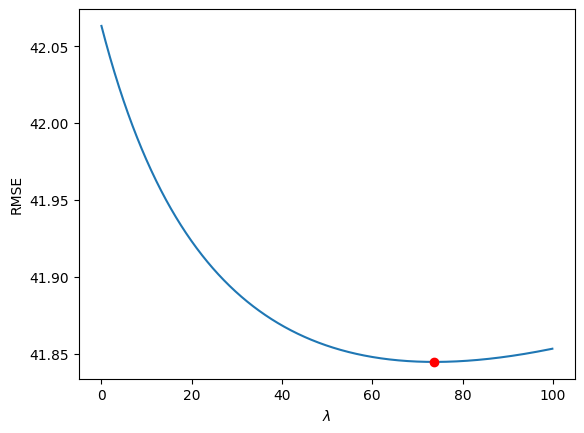

In [91]:
plt.plot(L, -rmse_L_k10, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(-rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, -rmse_min_k10, color='red', zorder=2)

#### **Lasso Regression ($l_2$ penalty)**

In [92]:
from sklearn.linear_model import Lasso

In [93]:
lassoreg = Lasso(alpha=1.0)
lassoreg.fit(X_train, y_train)
y_pred_lasso = lassoreg.predict(X_test)


In [94]:
rmse_lasso = calc_rmse(y_test, y_pred_lasso)
r2_lasso = calc_r2(y_test, y_pred_lasso)

print(r2_lasso)

-0.0932846825212279


In [95]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    
    lassoreg = Lasso(alpha=l)
    lassoreg.fit(X_train, y_train)
    y_pred_lasso = lassoreg.predict(X_test)
    
    rmse_L[i] = calc_rmse(y_test, y_pred_lasso)
    r2_L[i] = calc_r2(y_test, y_pred_lasso)

c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\room2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.868e+05, tolerance: 1.451e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_12596\1516381242.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$\lambda$')


Text(0, 0.5, 'RMSE')

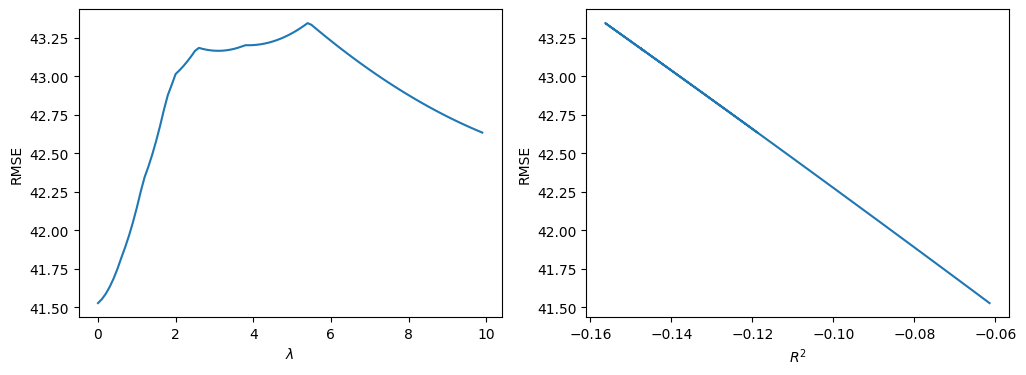

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(L, rmse_L)
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('RMSE')

ax2.plot(r2_L, rmse_L)
ax2.set_xlabel('$R^2$')
ax2.set_ylabel('RMSE')

### **Task 3: PCR and PLS Regression**

#### Principal Components Analysis

Covariance Matrix

In [97]:
X_train_for_pca = X_train.copy()
X_test_for_pca = X_test.copy()

X_train_for_pca = X_train_for_pca.drop(['intercept'], axis=1)
X_test_for_pca = X_test_for_pca.drop(['intercept'], axis=1)

In [98]:
cov_matrix = np.dot(X_train_for_pca.T, X_train_for_pca)/len(X_train_for_pca)
cov_eigenvalues, cov_eigenvectors = np.linalg.eig(cov_matrix)

In [99]:
sorted_indices = np.argsort(cov_eigenvalues)[::-1]
eigenvalues_sorted = cov_eigenvalues[sorted_indices]
eigenvectors_sorted = cov_eigenvectors[:, sorted_indices]

explained_variance = (eigenvalues_sorted/sum(eigenvalues_sorted))
explained_variance_cumulative = np.cumsum(explained_variance)

In [100]:
print(explained_variance_cumulative)

[0.29466497 0.4772772  0.62674864 0.759149   0.86707957 0.92462382
 0.97031803 0.98657111 1.        ]


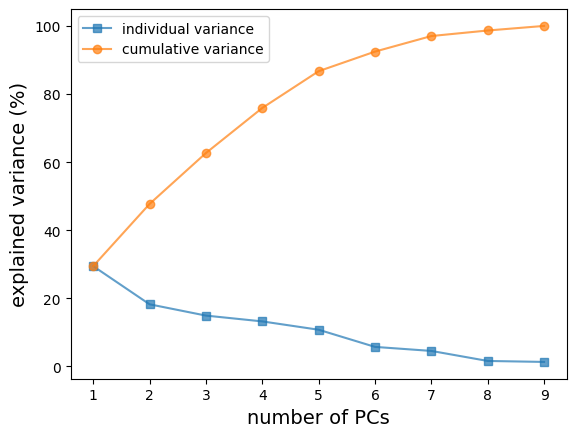

In [128]:
fig = plt.figure()

plt.plot(range(1,len(explained_variance_cumulative)+1), explained_variance*100, marker='s', alpha=0.7, label='individual variance')
plt.plot(range(1,len(explained_variance_cumulative)+1), explained_variance_cumulative*100, marker='o', alpha=0.7, label='cumulative variance')
plt.xlabel('number of PCs', fontsize=14)
plt.ylabel('explained variance (%)', fontsize=14)
plt.legend(fontsize=10)

# fig.savefig('../ica2024-report/homework2/figures/pca.pdf', format='pdf', bbox_inches='tight')

fig.savefig('../ica2024-report/presentation/figures/pca.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [102]:
k = 7
V_k = eigenvectors_sorted[:, :k]
X_train_pca = np.dot(X_train_for_pca, V_k)
X_test_pca = np.dot(X_test_for_pca, V_k)

In [103]:
X_train_pca = np.column_stack((np.ones(X_train_pca.shape[0]), X_train_pca))
X_test_pca = np.column_stack((np.ones(X_test_pca.shape[0]), X_test_pca))


In [104]:
rmse_pcr, r2_pcr, y_pred_pcr = ica_linear_regression(X_train_pca, y_train, X_test_pca, y_test)

In [105]:
print(rmse_pcr)
print(r2_pcr)

42.2696603649221
-0.09963930214380379


### **Task 4: Neural Network for Regression**

\begin{align*}
    y = f(\mathbf{X}) = & \beta_0 + \displaystyle \sum_{k=1}^{K} \beta_k h_k(\mathbf{X}) \\
    = & \beta_0 + \sum_{k=1}^K \beta_k \cdot g(\omega_{k0} + \sum_{j=1}^{p} \omega_{kj}\mathbf{X}_j)
\end{align*}

\begin{equation*}
    A_k = h_k(\mathbf{X}) = g(\omega_{k0} + \sum_{j=1}^{p} \omega_{kj}\mathbf{X}_j)
\end{equation*}

\begin{equation*}
\underset{\{\omega_k\}_1^K, \beta}{min} \cfrac{1}{2} \sum_{i=1}^{n} (y_i - f(x_i))^2, 
\end{equation*}

where

\begin{equation*}
    f(x_i) = \beta_0 + \displaystyle \sum_{k=1}^{K} \beta_k g(\omega_{k0} + \sum_{j=1}^p \omega_{kj}x_{ij})
\end{equation*}

\begin{align*}
    R(\theta) = & \cfrac{1}{2} \sum_{i=1}^n (y_i - f_\theta (x_i))^2 \\
              = & \sum_{i=1}^n R_i(\theta)
\end{align*}

Backpropagation

$$
    \Delta R(\theta^m) = \cfrac{\partial R(\theta)}{\partial \theta} \bigg|_{\theta = \theta^m}
$$

$$
    \theta^{m+1} = \theta^m - \rho \Delta R(\theta^m)
$$

$$
    R_i(\theta) = \cfrac{1}{2} \left(y_i - \beta_0 - \sum_{k=1}^K \beta_k g\left(\omega_{k0} + \sum_{j=1}^p \omega_{kj} x_{ij}\right)\right)^2
$$

making $z_{ik} = \omega_{k0} + \sum_{j=1}^{p} \omega_{kj} x_{ij}$

* Taking the derivative with respect to $\beta_k$:

$$
    \cfrac{\partial R_{i}(\theta)}{}
$$

In [106]:
X_train_nn = X_train.drop(['intercept'], axis=1)
X_test_nn = X_test.drop(['intercept'], axis=1)

In [107]:
import keras
from keras import layers

In [108]:
model_nn = keras.Sequential([
    layers.Input(shape=(9,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

In [109]:
model_nn.compile(optimizer='adam', loss='mean_squared_error')

In [110]:
model_nn.fit(X_train_nn, y_train, epochs=300, batch_size=32, validation_data=(X_test_nn, y_test))

Epoch 1/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 76101.4531 - val_loss: 83163.0391
Epoch 2/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 75413.2031 - val_loss: 82997.7578
Epoch 3/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76085.8672 - val_loss: 82816.8359
Epoch 4/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74776.9922 - val_loss: 82600.2266
Epoch 5/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76856.3125 - val_loss: 82313.0781
Epoch 6/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 73960.5625 - val_loss: 81937.1250
Epoch 7/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74466.9297 - val_loss: 81425.0469
Epoch 8/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 72273.0547 - val_loss: 80748.0312
Epoch 9/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 74014.4609 - val_loss: 79865.0625
Epoch 10/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 72647.0469 - val_loss: 78665.6641
Epoch 11/300
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69667.53

In [111]:
y_pred_nn = model_nn.predict(X_test_nn)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


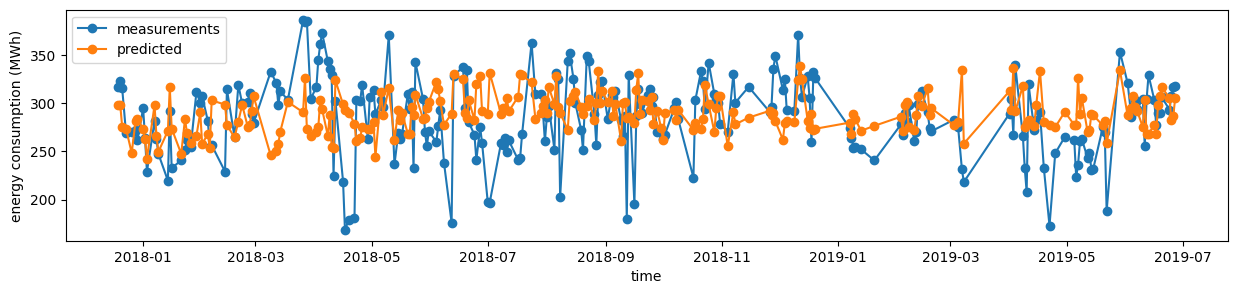

In [112]:
plt.figure(figsize=(15,3))

plt.plot(time_test, y_test, label='measurements', marker='o')
plt.plot(time_test, y_pred_nn, label='predicted', marker='o')

plt.xlabel('time')
plt.ylabel('energy consumption (MWh)')
plt.legend()

plt.show()

In [113]:
y_pred_nn = y_pred_nn.ravel()

In [114]:
calc_rmse(y_test, y_pred_nn)

42.302414949586314

In [115]:
calc_r2(y_test,y_pred_nn)

-0.1013441743144885

In [125]:
fsa = 18
fsl = 12
fst = 14

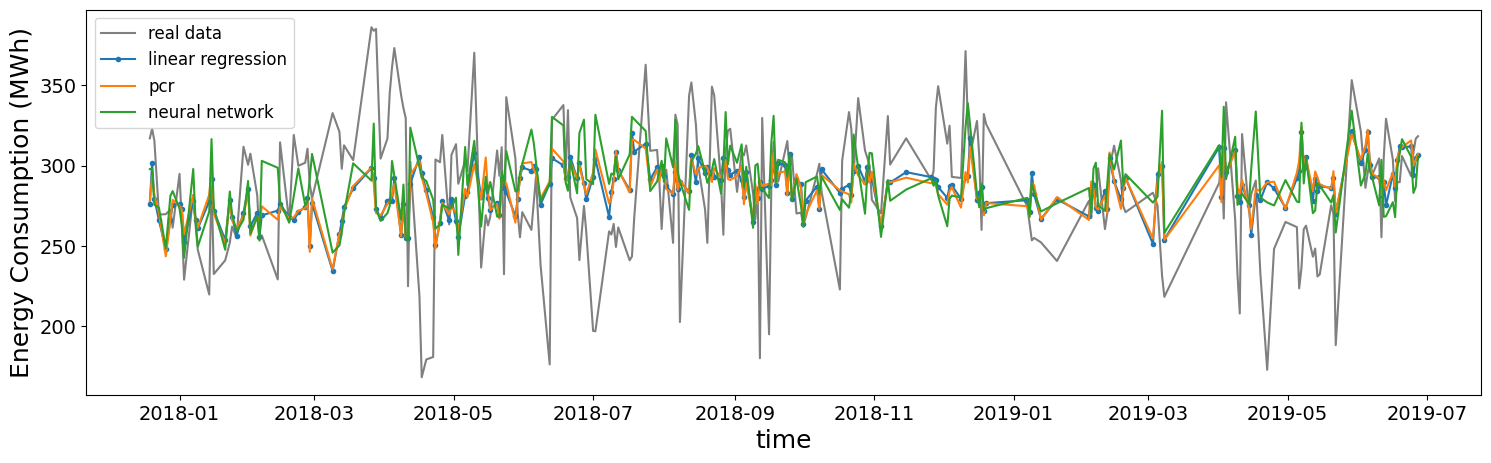

In [127]:
fig = plt.figure(figsize=(18,5))

plt.plot(time_test, y_test, label='real data', color='gray')# , marker='o', markersize=4)
plt.plot(time_test, y_pred_olr, label='linear regression', marker='o', markersize=3)
plt.plot(time_test, y_pred_pcr, label='pcr')
plt.plot(time_test, y_pred_nn, label='neural network')

plt.xlabel('time', fontsize=fsa)
plt.ylabel('Energy Consumption (MWh)', fontsize=fsa)

plt.xticks(fontsize=fst)
plt.yticks(fontsize=fst)

plt.legend(fontsize=fsl)

# fig.savefig('../ica2024-report/homework2/figures/regression-results.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../ica2024-report/presentation/figures/regression-results.pdf', format='pdf', bbox_inches='tight')

plt.show()

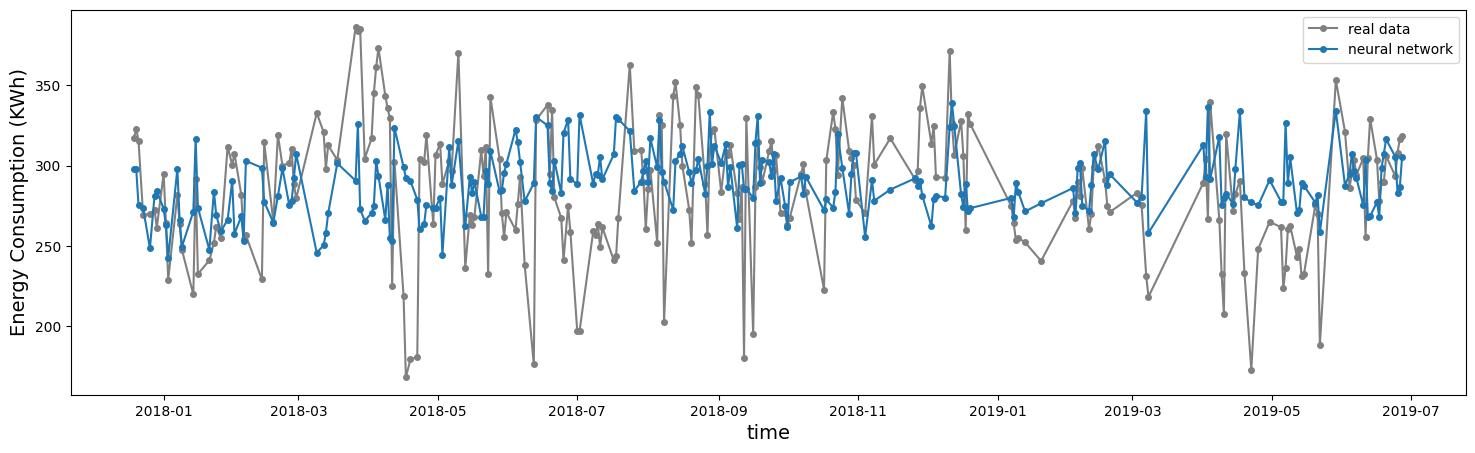

In [118]:
fig = plt.figure(figsize=(18,5))

plt.plot(time_test, y_test, label='real data', color='gray', marker='o', markersize=4)
plt.plot(time_test, y_pred_nn, label='neural network', marker='o', markersize=4)

plt.xlabel('time', fontsize=fsa)
plt.ylabel('Energy Consumption (KWh)', fontsize=fsa)

plt.legend(fontsize=fsl)

# fig.savefig('../ica2024-report/homework2/figures/neural-network-results.pdf', format='pdf', bbox_inches='tight')

plt.show()

##### **References**

James, Gareth, et al. *An introduction to statistical learning*. Vol. 112. New York: springer, 2013.

Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. *The elements of statistical learning: data mining, inference, and prediction*. (2017).

Hastie, Trevor, Robert Tibshirani, and Martin Wainwright. "Statistical learning with sparsity." Monographs on statistics and applied probability 143.143 (2015): 8.